In [5]:
import os
import torch
import datasets.gapfill
import options.common
import options.gan
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import yaml
from pathlib import Path

In [2]:
print(os.getcwd())

/workspace/gfm-gap-filling-baseline/gap-filling-baseline


In [3]:
local_rank = 1
mean = torch.tensor([495.7316,  814.1386,  924.5740, 2962.5623, 2640.8833, 1740.3031])[None,:,None,None,None].to(local_rank)
std = torch.tensor([286.9569, 359.3304, 576.3471, 892.2656, 945.9432, 916.1625])[None,:,None,None,None].to(local_rank)


In [11]:
device = torch.device("cuda:{}".format(local_rank))
torch.cuda.set_device(device)

In [6]:
checkpoint = Path("subset_6231_2023-08-20-17:01:03_uneven_bs16")
checkpoint_dir = Path("/workspace/gfm-gap-filling-baseline/data/results") / checkpoint
g_net_checkpoint = Path("/workspace/gfm-gap-filling-baseline/data/results") / checkpoint / "model_gnet_best.pt"

In [7]:
with open(checkpoint_dir / "config.yml", "r") as cfg_file:
    CONFIG = yaml.safe_load(cfg_file)

In [8]:
train_transforms, test_transforms = options.common.get_transforms(CONFIG)

val_dataset = options.common.get_dataset(CONFIG, split="validate", transforms=train_transforms)
val_chip_dataframe = pd.DataFrame(val_dataset.tif_catalog)

print(f"Number of validation images: {len(val_dataset)}")
print(f"Number of validation cloud masks: {val_dataset.n_cloudpaths}")

Number of validation images: 1621
Number of validation cloud masks: 1600


In [12]:
g_net = options.gan.get_generator(CONFIG).to(device)

g_net_state_dict = torch.load(g_net_checkpoint)

g_net.load_state_dict(g_net_state_dict)

<All keys matched successfully>

In [33]:
sample = val_dataset[640]
sample = {k: v.unsqueeze(0).to(device) for k, v in sample.items()}
g_input = sample["masked"]
dest_fake = g_net(g_input)
gen_unmasked = dest_fake * sample["cloud"]
gen_reconstruction = gen_unmasked + sample["masked"]


In [34]:
B4_non_cloud = sample["masked"][0,9,:,:].detach().cpu().numpy()
B5_non_cloud = sample["masked"][0,10,:,:].detach().cpu().numpy()
B4_true = sample["unmasked"][0,9,:,:].detach().cpu().numpy()
B5_true = sample["unmasked"][0,10,:,:].detach().cpu().numpy()
B4_gen = gen_unmasked[0,9,:,:].detach().cpu().numpy()
B5_gen = gen_unmasked[0,10,:,:].detach().cpu().numpy()
B4_non_cloud[B4_non_cloud == 0] = np.nan
B5_non_cloud[B5_non_cloud == 0] = np.nan
B4_gen[B4_gen == 0] = np.nan
B5_gen[B5_gen == 0] = np.nan
B4_true[B4_true == 0] = np.nan
B5_true[B5_true == 0] = np.nan

NameError: name 'save_dir' is not defined

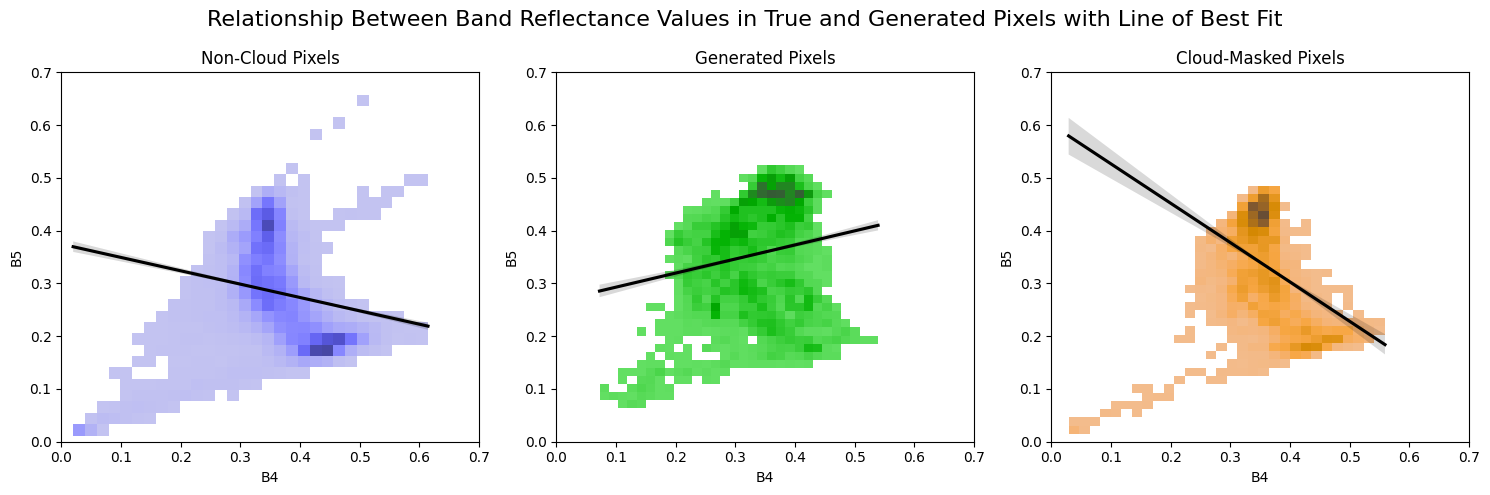

In [35]:
non_cloud_data = pd.DataFrame({
    'B4': B4_non_cloud.flatten(),
    'B5': B5_non_cloud.flatten(),
    'type': 'non_cloud'
})
gen_data = pd.DataFrame({
    'B4': B4_gen.flatten(),
    'B5': B5_gen.flatten(),
    'type': 'gen'
})
true_data = pd.DataFrame({
    'B4': B4_true.flatten(),
    'B5': B5_true.flatten(),
    'type': 'true'
})


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.histplot(non_cloud_data, x="B4", y="B5", bins=30, ax=axes[0], color='blue')
axes[0].set_xlim(0, 0.7)
axes[0].set_ylim(0, 0.7)
axes[0].set_xlabel('Red Reflectance')
axes[0].set_ylabel('NIR Reflectance')
axes[0].set_title('Non-Cloud Pixels')
sns.regplot(non_cloud_data, x="B4", y="B5", ax=axes[0], scatter=False, color='black')

sns.histplot(gen_data, x="B4", y="B5", bins=30, ax=axes[1], color='green')
axes[1].set_xlim(0, 0.7)
axes[1].set_ylim(0, 0.7)
axes[1].set_xlabel('Red Reflectance')
axes[1].set_ylabel('NIR Reflectance')
axes[1].set_title('Generated Pixels')
sns.regplot(gen_data, x="B4", y="B5", ax=axes[1], scatter=False, color='black')

sns.histplot(true_data, x="B4", y="B5", bins=30, ax=axes[2], color='orange')
axes[2].set_xlim(0, 0.7)
axes[2].set_ylim(0, 0.7)
axes[2].set_xlabel('Red Reflectance')
axes[2].set_ylabel('NIR Reflectance')
axes[2].set_title('Cloud-Masked Pixels')
sns.regplot(true_data, x="B4", y="B5", ax=axes[2], scatter=False, color='black')

# Set a common title for all subplots
plt.suptitle(f'Relationship Between Band Reflectance Values in True and Generated Pixels with Line of Best Fit', fontsize=16)

# Adjust layout for better spacing between subplots
plt.tight_layout()
filename = 'B4_B5_Graph.png'
print(str(save_dir / filename))
plt.savefig(save_dir / filename, format='png')
